In [1]:
import csv 
import numpy as np
import matplotlib.pyplot as plt
import math
import ctypes as ct
import scipy.interpolate
import time
from aerofiles.igc import Reader

from scipy.optimize import minimize
from IPython.display import display, clear_output

import plotly.graph_objects as go

import pandas as pd

import concurrent.futures
import multiprocessing
import os



In [2]:
# Function to read airfoil data at each station
 
def GetAirfoilData(Filename):
    with open(Filename, 'r') as infile:
        AirfoilData = np.loadtxt(infile, dtype=str, skiprows=0, unpack=True)
    
    return AirfoilData

In [3]:
# Function to read wing geometry

def GetWingData(Filename):
    with open(Filename, 'r') as infile:
        WingData = np.loadtxt(infile, dtype=float, skiprows=0, unpack=True)
    area = 0
    span = 0
    
    for i in range(0,len(WingData[0]),1):
        span = span + WingData[2][i]
        area = area + ((WingData[0][i] + WingData[1][i])/2)*WingData[2][i]
    
    AR = 2*(span**2)/area
    
    return area, span,AR,WingData
    



# CALL XFOIL

In [4]:
def CallXfoilcl(Cl, Re, AirfoilName, Flap,xpos,ypos):

    
    mydll = ct.cdll.LoadLibrary("../XFOIL/XFOIL.dll")

    if os.path.exists(AirfoilName) == True:
        ISCONV = ct.c_bool(False)
        RE_IN = ct.c_double(Re)
        CL_IN = ct.c_double(Cl)
        array = (ct.c_double * 11) (0,0,0,0,0,0,0,Flap,xpos,ypos,0)
        l = ct.c_int(0)
        my_string = AirfoilName.encode() # Convert string to bytes
        l = len(my_string)
        _= mydll.xfoil_cl(ct.byref(array), ct.byref(CL_IN),ct.byref(RE_IN),ct.byref(ISCONV),ct.c_char_p(my_string),ct.c_int(l))

                # Array1(1) = ADEG
                # Array1(2) = CD
                # Array1(3) = CDF
                # Array1(4) = CM
                # Array1(5) = HMOM
                # Array1(6) = HFX
                # Array1(7) = HFY
        if ISCONV.value == False:
            print(AirfoilName,Re,Cl,array[1])         #[uncomment if you want to see whether iteration for station has converged]
        return array[0],array[1],array[3],ISCONV.value
    else:
        print("Airfoil Filename does not exist->" + str(AirfoilName))
        return(1,1,1,False)


In [69]:
AOA, Cd,Cm,ISCONV = CallXfoilcl(0.5,1000000,'./AIRFOILS/L4',0,0.86,0)

print(AOA,Cd,Cm,ISCONV)

1.842209815979004 0.005561030004173517 -0.04563474282622337 True


In [ ]:
0.19197331368923187 0.006212384905666113 -0.1007268875837326 True

# AIRFOIL ANALYSIS


In [ ]:
# AIRFOIL ANALYSIS II PARALLEL PROCESSING   (FLAP AUTO RANGES - BEST FLAP)

n = 60 
rho = 1.225
mu = 1.789e-5
#V_inf = 40         #[m/s]
alpha = 5          # angle of attack (only for Lifting line solver) [deg]
a = 2*np.pi        # lift curve slope
Weight = 550*9.81  #[N]
Bank_Angle = 0     #[deg]
Flap = 0           #[0 degrees is neutral or no flap]
Pressure_altitude = 0  #[m]
OAT = 15  #[Deg]



Area,Span,AR, WingData = GetWingData("JS6_b_wing_18m.dat")
ChordData  = GetAirfoilData("JS6_b_Airfoil_Data.dat")  


Airfoil_foldername = "./AIRFOILS/"
with open("AIRFOIL_ANALYSIS.dat", 'r') as infile:
     Airfoils = np.loadtxt(infile, dtype=str, skiprows=0, unpack=True)

        



with open("SPEED_SETTINGS.dat", 'r') as infile:
     SPEEDFLAP = np.loadtxt(infile, dtype=str, skiprows=0, unpack=True)


cl,y_pos,CL_theory,delta = Solve_LL(WingData,Span,AR,alpha,a,n)   
#set cl interpolation function 
cl_interp = scipy.interpolate.interp1d(y_pos,cl)


Station = 2                                             #  STATION

span = 0
for i in range(0,Station-1,1):
    span = span + 0.995*WingData[2][i]
print(span)



filename1 = "Airfoil_analysis.csv"
filename2 = "Airfoil_flap_vs_drag.csv"
csvfile1 = open(filename1, 'w')
csvfile2 = open(filename2, 'w')
csvwriter1 = csv.writer(csvfile1)
csvwriter2 = csv.writer(csvfile2)

csvheader1 = Airfoils[0]
csvheader1 = np.insert(csvheader1, 0,"CL")

csvheader2 = []

#print(csvheader)
csvwriter1.writerow(csvheader1)   



num_processes = multiprocessing.cpu_count()
print(num_processes)

step = 1

for k in range(0,len(SPEEDFLAP[0]),1):
    
    i = Station-1
    Airfoil_min = "none"
    flapsetting = "99"
    V_inf = float(SPEEDFLAP[0][k])/3.6
    Re = rho*V_inf*float(ChordData[1][i])/mu
    #print(V_inf,Re)
    CL = (2*Weight) /  (rho*(V_inf)**2  *2*Area*np.cos(np.deg2rad(Bank_Angle)))    

    print("Station->"+str(i+1) + "  " + str(SPEEDFLAP[0][k])+"km/h  " + "CL = "+str(cl_interp(span)*CL) + " RE = " + str(Re))
 
    ISCONV = True
    cd_collector = []
    rowlist = []
    flaplist = []
    m = np.arange(float(SPEEDFLAP[1][k]),float(SPEEDFLAP[2][k])+step,step)
    
    csvheader2 = []
    
    for v in range(0,len(m),1):
        csvheader2.append(str(m[v]))
    
    csvheader2.insert(0,"FLAP")
    csvheader2.append('')
    csvheader2.append('')
    csvheader2.append('')
    csvwriter2.writerow(csvheader2) 
    csvheader2.clear()
    
    
    rowlist.append(float(cl_interp(span)*CL))
    
    for j in range(0,len(Airfoils[0]),1):
        
        Cd_min_airfoil = 0.1
        Flap_min = "-99"
     
        cdlist = [1]*len(m)
        
        
        def min_drag(fl):
            xpos = float(Airfoils[1][j])
            ypos = float(Airfoils[2][j])
            AOA, Cd,Cm,ISCONV = CallXfoilcl(cl_interp(span)*CL,Re,Airfoil_foldername + Airfoils[0][j],fl,xpos,ypos)
            #Cd = 0.005
            if ISCONV == True:
                return Airfoils[0][j],'{:.5f}'.format(Cd), fl
            else:
                return Airfoils[0][j],1,1 
        
        #cdlist = np.insert(cdlist, 0,Airfoils[0][j])
         
        
        with multiprocessing.Pool(processes=num_processes) as pool:
            cd_collector = pool.map(min_drag,m)        
          
        
        a = []
        
        for l in range(0,len(m),1):
            a.append(str(cd_collector[l][1]))
            if float(cd_collector[l][1]) < Cd_min_airfoil:
                Cd_min_airfoil = float(cd_collector[l][1])
                Flap_min = cd_collector[l][2]
        
        
        a.insert(0,Airfoils[0][j])
        csvwriter2.writerow(a) 
        print(Airfoils[0][j],Cd_min_airfoil,Flap_min)    #uncomment to print details
        
        #print(cd_collector)
        #print(Airfoils[0][j],min(cd_collector)) 
        #print(flaplist)
            
        
        rowlist.append(Cd_min_airfoil)  
        flaplist.append(Flap_min)    #not written to csv file currently
  
    # print(rowlist)
    # print(flaplist)
    csvwriter1.writerow(rowlist) 
    
csvfile1.close()
csvfile2.close()
print("Done")       
    

In [11]:
# AIRFOIL ANALYSIS        (FIXED FLAP from file)


with open("SPEED_SETTINGS_SC.dat", 'r') as infile:
     SPEEDFLAP = np.loadtxt(infile, dtype=str, skiprows=0, unpack=True)

    
n = 60 
rho = 1.225
mu = 1.789e-5
#V_inf = 40         #[m/s]
alpha = 5          # angle of attack (only for Lifting line solver) [deg]
a = 2*np.pi        # lift curve slope
Weight = 525*9.81  #[N]
Bank_Angle = 0     #[deg]
Flap = 0           #[0 degrees is neutral or no flap]
Pressure_altitude = 0  #[m]
OAT = 15  #[Deg]


Area,Span,AR, WingData = GetWingData("JS4_wing_15m.dat")
ChordData  = GetAirfoilData("JS4_Airfoil_Data.dat")



cl,y_pos,CL_theory,delta = Solve_LL(WingData,Span,AR,alpha,a,n)   
#set cl interpolation function 
cl_interp = scipy.interpolate.interp1d(y_pos,cl)
    
    
    
Airfoil_foldername = "./AIRFOILS/SC/"
with open("AIRFOIL_ANALYSIS_SC.dat", 'r') as infile:
     Airfoils = np.loadtxt(infile, dtype=str, skiprows=0, unpack=True)

        

filename = "Airfoil_analysis.csv"


Station = 1                                           #  STATION

span = 0.01
for i in range(0,Station-1,1):
    span = span + 0.995*WingData[2][i]
print("Span pos->"+str(span))


csvfile = open(filename, 'w')
csvwriter = csv.writer(csvfile) 



csvheader = Airfoils[0]
csvheader = np.insert(csvheader, 0,"CL")

print(csvheader)
csvwriter.writerow(csvheader)   

num_processes = multiprocessing.cpu_count()
print(num_processes)





for k in range(0,len(SPEEDFLAP[0]),1):
    
    i = Station-1
    Airfoil_min = "none"

    V_inf = float(SPEEDFLAP[0][k])/3.6
    Re = rho*V_inf*float(ChordData[1][i])/mu
    #print(V_inf,Re)
    CL = (2*Weight) /  (rho*(V_inf)**2  *2*Area*np.cos(np.deg2rad(Bank_Angle)))    
    
    m = float(SPEEDFLAP[3][k])    #fixed flap setting from file 
    
    print("Station->"+str(i+1) + "  " + str(SPEEDFLAP[0][k])+"km/h  " + "Cl = "+str(cl_interp(span)*CL) + " RE = " + str(Re) + " FLAP =" + str(m))
 
    ISCONV = True
    cd_collector = []
    rowlist = []
    flaplist = []
    
    rowlist.append(float(cl_interp(span)*CL))
    for j in range(0,len(Airfoils[0]),1):
        step = 1
        Cd_min_airfoil = 0.1
        Flap_min = "-99"
        
       
        xpos = float(Airfoils[1][j])
        ypos = float(Airfoils[2][j])
        AOA, Cd,Cm,ISCONV = CallXfoilcl(cl_interp(span)*CL,Re,Airfoil_foldername + Airfoils[0][j],m,xpos,ypos)
#         if ISCONV == True:
#             return Airfoils[0][j],'{:.5f}'.format(Cd), m
#         else:
#             print("not converged")
#             return Airfoils[0][j],1,1 
    

        # with multiprocessing.Pool(processes=num_processes) as pool:
        #     cd_collector = pool.map(min_drag,m)        
        
        
        # for l in range(0,len(m),1):
        #     if float(cd_collector[l][1]) < Cd_min_airfoil:
        #         Cd_min_airfoil = float(cd_collector[l][1])
        #         Flap_min = cd_collector[l][2]
                
        
        #print(Airfoils[0][j],Cd_min_airfoil,Flap_min)    #uncomment to print details
        
        if ISCONV == True:
            print(Airfoils[0][j],'{:.5f}'.format(Cd))
            rowlist.append(Cd) 
        else:
            print(Airfoils[0][j],'Not converged')
            rowlist.append(' ')
             
         
        flaplist.append(Flap_min)    #not written to csv file currently
  
    # print(rowlist)
    # print(flaplist)
    csvwriter.writerow(rowlist) 
    
csvfile.close()
print("Done")       
    

Span pos->0.01
['CL' 'STmod11' '5mod' 'O20' 'O11' 'OPT110' 'ST1'
 'Airfoil_Station_5_smooth.dat']
128
Station->1  95km/h  Cl = 1.2116577721906594 RE = 1481701.4471150863 FLAP =0.0
STmod11 0.00884
5mod 0.02452
./AIRFOILS/SC/O20 1481701.4471150863 1.2116577721906594 0.19399960339069366
O20 Not converged
O11 0.01111
OPT110 0.00818
ST1 0.00975
Airfoil_Station_5_smooth.dat 0.01436
Station->1  110km/h  Cl = 0.9037364788446862 RE = 1715654.3071858892 FLAP =0.0
STmod11 0.00588
5mod 0.00504
O20 0.00538
O11 0.00753
OPT110 0.00558
ST1 0.00595
Airfoil_Station_5_smooth.dat 0.00583
Station->1  140km/h  Cl = 0.5579189486745256 RE = 2183560.0273274947 FLAP =0.0
STmod11 0.00462
5mod 0.00445
O20 0.00464
O11 0.00496
OPT110 0.00456
ST1 0.00461
Airfoil_Station_5_smooth.dat 0.00442
Station->1  170km/h  Cl = 0.3783810170941419 RE = 2651465.7474691016 FLAP =0.0
STmod11 0.00431
5mod 0.00405
O20 0.00423
O11 0.00417
OPT110 0.00425
ST1 0.00410
Airfoil_Station_5_smooth.dat 0.00410
Station->1  200km/h  Cl = 0.27338

In [73]:
# SAMPLE CODE   (RUN XFOIL FOR SINGLE CASE)

CL = 0.643
Re = 1693780
Airfoil_foldername = "./AIRFOILS/"
Airfoilname = "L7"
Flap = 3
xpos = 0.85
ypos = 0.0

AOA, Cd,Cm,ISCONV = CallXfoilcl(CL,Re,Airfoil_foldername + Airfoilname,Flap,xpos,ypos)

print('{:.5f}'.format(Cd))

0.00411


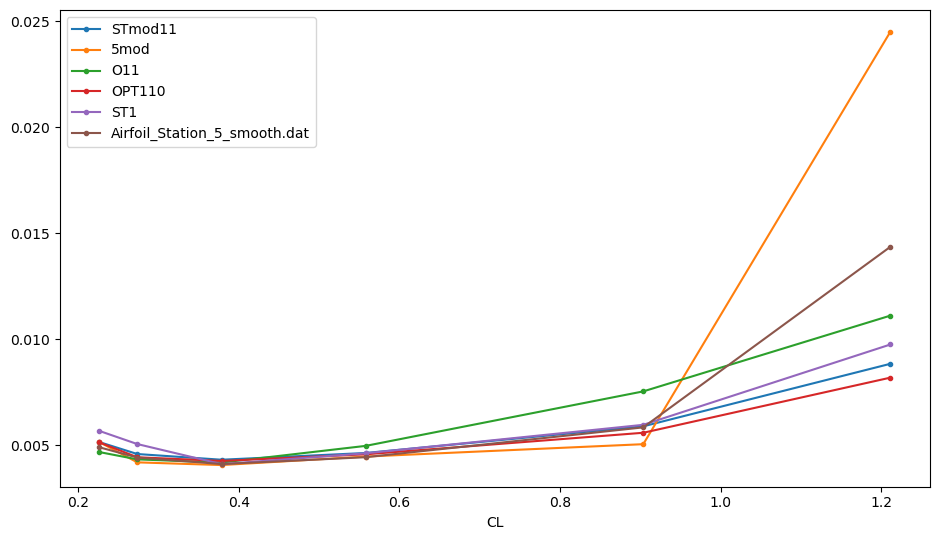

In [12]:
# MAKE A CHART FROM MINIMUM AIRFOIL CD VALUES

plt.rcParams["figure.figsize"] = [9.50, 5.50]
plt.rcParams["figure.autolayout"] = True

#markers = ['o', 's', 'D', 'p', '*', 'h']
#df.plot(x='X', y='Y', marker=markers, linestyle='-', figsize=(8, 6))


df = pd.read_csv('Airfoil_analysis.csv')
df.set_index('CL').plot(marker = ".")
plt.show()

In [9]:
#SAMPLE CODE

Area,Span,AR, WingData = GetWingData("JS6_wing_18m.dat")
print(WingData)
print("Number of panels => " + str(WingData[0].size))
print("Aspect Ratio => " + str(AR))
print("Area => " + str(Area*2))
print("Span => " + str(Span*2))
#print(dir(WingData))

[[ 0.765       0.695       0.591       0.465       0.324     ]
 [ 0.695       0.591       0.465       0.324       0.159     ]
 [ 3.285       2.254       1.528       1.034       0.899     ]
 [ 1.17700929  1.73317762  0.98190798  0.8606      0.2194    ]
 [ 2.          2.          4.24        6.47       18.93      ]
 [ 1.59702753  2.60041654  1.79507858  2.154       0.84444444]]
Number of panels => 5
Aspect Ratio => 30.686598433183956
Area => 10.558355
Span => 18.0


In [10]:
rho = 1.225
mu = 1.789e-5
V_inf = 30


In [ ]:
#SAMPLE CODE


AirfoilData  = GetAirfoilData("JS4_Airfoil_Data.dat")
print(AirfoilData)


for i in range(0,len(AirfoilData[0]),1):
    Re = rho*V_inf*float(AirfoilData[1][i])/mu
    
    # call XFOIL DLL
    AOA, Cd,Cm = CallXfoilcl(0,Re,AirfoilData[0][i],0)
    print(i+1,AirfoilData[1][i],Re,AOA, Cd, Cm)
    

In [11]:
# Function to divide wing into n sections, returns chord lengths array
#NOT USED


def WingDivide(WingData,n):
    number_of_panels = WingData[0].size

    #determine wing span from wing file
    span = 0
    if number_of_panels > 1:
        for panel_length in WingData[5]:
            span = span + panel_length 
    else:
        span = WingData[5]
        
    #print("Wing span => " + str(2*span))
    
    
    # divide wing into n sections
    chords = np.zeros(n, dtype=float)
    current_panel = 0 
    current_span_pos = WingData[5][0]
    i = 0
    for y_pos in np.linspace(0,span, n):
           
        if y_pos > current_span_pos:
            current_panel = current_panel + 1
            current_span_pos = current_span_pos + WingData[5][current_panel]
        
        chords[i] = ((WingData[0][current_panel] - WingData[1][current_panel]) / WingData[5][current_panel]) * (current_span_pos - y_pos) + WingData[1][current_panel]
        i += 1
    #print(np.stack((np.linspace(0,span,n),chords),axis=1))    
    return(np.stack((np.linspace(0,span,n),chords),axis=1))
 
    
    

In [5]:
def Get_Chord(WingData,y_pos):
    chord = 0
    number_of_panels = WingData[0].size

    #determine wing span from wing file
    span = 0
    if number_of_panels > 1:
        for panel_length in WingData[2]:
            span = span + panel_length 
    else:
        span = WingData[2]
        
    #print("Wing half span => " + str(span))
    
    
   
   
    current_panel = 0
    current_span_pos = WingData[2][0]   #outer section of current panel
     
    while current_panel <= number_of_panels+1:
        if y_pos < current_span_pos:
                chord = ((WingData[0][current_panel] - WingData[1][current_panel]) / WingData[2][current_panel]) * (current_span_pos - y_pos) + WingData[1][current_panel]
                break
        
        current_panel += 1 
        current_span_pos = current_span_pos + WingData[2][current_panel]
               
        #print(current_panel,current_span_pos)
        
    
    
    #print(np.stack((np.linspace(0,span,n),chords),axis=1))    
    return(chord)

In [6]:
def Solve_LL(wingdata,span,AR,alpha,a,n):
    
    #a is the lift slope cl/radians  -> 2*PI
    
    theta_range = np.linspace(90,0.01,n)
    AMatrix = np.ones(shape=(n,n))
    X = np.ones(n)
    delta = 0
    Cl = np.zeros(n)
    y_pos = np.zeros(n)
    
    
    i = 0
    for theta in theta_range:
        unit_y = -math.cos(np.deg2rad(theta)) 
        c = Get_Chord(wingdata,-unit_y*span)
        mu = c*a/(8*span)
        
        X[i] = mu*(np.deg2rad(alpha))*(math.sin(np.deg2rad(theta)))
        for j in range(0,n,1):
            AMatrix[i][j] = (math.sin(((j+1)*2 -1)*np.deg2rad(theta)))*(((j+1)*2-1)*mu + (math.sin(np.deg2rad(theta))))
        
        y_pos[i] = -unit_y*span
        i+=1
    
    #print(A)
    #print(X)      
    #A = np.matmul(np.linalg.inv(AMatrix),X)
    A = np.linalg.solve(AMatrix, X)
    
    
    for i in range(1,n,1):
        delta = delta +((i+1)*2-1)*(A[i]**2)/(A[0]**2)

    #e =  (1/(1+delta))     

    k = 0
    for theta in theta_range:  
        for j in range(0,n,1):
            unit_y = -math.cos(np.deg2rad(theta))
            c = Get_Chord(wingdata,-unit_y*span)
            Cl[k] = Cl[k]+ (8*span)*(A[j]*(math.sin(((j+1)*2-1)*np.deg2rad(theta)))) / c
            
        k+=1
           
    CL = A[0]*(np.pi)*AR
    Cl_unit = Cl/CL
    return(Cl_unit,y_pos,CL,delta) 
          
    

# OPTIMIZE PLANFORM

Area => 10.247737024106664
Span => 15.079999999999998
Span efficiency delta => 99.5014250585251
CL => 0.5023227901854372
[0.83996849 0.83909622 0.7265915  0.54489976 0.34610812 0.21      ]


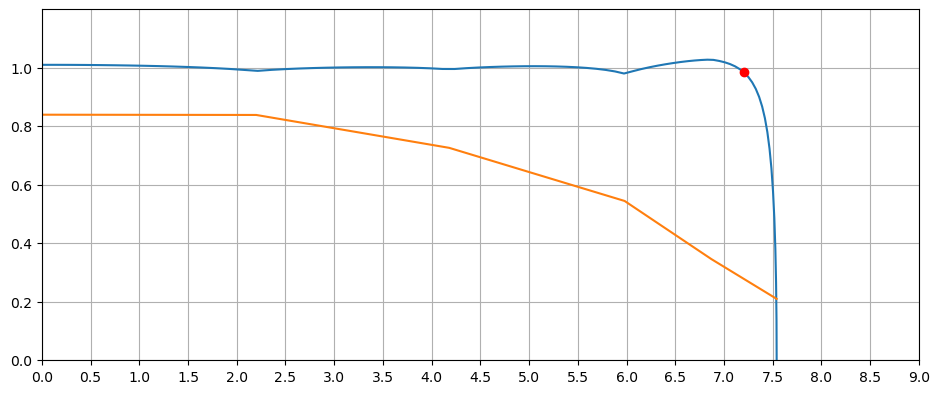

In [71]:
# SAMPLE CODE


n = 80
a = 2*np.pi
alpha = 5

Area,Span,AR, WingData = GetWingData("JS4b_wing_15m.dat")
#print(WingData)
Cl,y_pos,CL,Delta = Solve_LL(WingData,Span,AR,alpha,a,n)

def get_max_eff(y):

    for i in range(0,len(WingData[0]),1):
        WingData[0][i] = y[i]
        
        if i < len(WingData[0])-1:
            WingData[1][i] = y[i+1]      #Last panel chord stays constant
        
    Cl,y_pos,CL,Delta = Solve_LL(WingData,Span,AR,alpha,a,n)  
    clear_output()
    print(Delta)
  
    return Delta

y0 = [0.80, 0.79, 0.7, 0.5, 0.419]                               # -> example guess values 
bnds = ((0.65,0.84),(0.62,0.85),(0.45,0.77),(0.4,0.65),(0.30,0.55))        # ->  BOUNDS





#y0 = [0.72, 0.653, 0.517, 0.354]                               # -> example guess values 
#bnds = ((0.72,0.76),(0.35,0.70),(0.28,0.55),(0.35,0.5))        # ->  BOUNDS

#d = get_max_eff(y0)

#[0.75151919 0.69823898 0.59855691 0.47117237 0.32582801 0.159]

res = minimize(get_max_eff, y0, method="Nelder-Mead",options={'disp':True, 'fatol':1e-03},bounds=bnds)

clear_output()

Area = 0
Span = 0
   
for i in range(0,len(WingData[0]),1):
    Span = Span + WingData[2][i]
    Area = Area + ((WingData[0][i] + WingData[1][i])/2)*WingData[2][i]

AR = 2*(Span**2)/Area

Cl,y_pos,CL,Delta = Solve_LL(WingData,Span,AR,alpha,a,n)


print("Area => " + str(Area*2))
print("Span => " + str(Span*2))
print("Span efficiency delta => " + str(1/(1+Delta)*100))  
print("CL => " + str(CL))

#print(Cl)                    #Unit local Cl distribution
#print(y_pos)                 #span position for each local lift coefficient)


fig, ax1 = plt.subplots()
ax1.set(xlim=(0, 9), xticks=np.arange(0, 9.5,0.5), 
       ylim=(0, 1.2), yticks=np.arange(0, 1.2,0.2))
ax1.plot(y_pos, Cl)
Cl_interp = scipy.interpolate.interp1d(y_pos,Cl)
spanpoint = 7.2
ax1.plot(spanpoint,Cl_interp(spanpoint),'ro')
ax1.grid(True)
ax1.set_box_aspect(0.4)


x0=[0]*(len(WingData[0])+1)
for i in range(1,len(WingData[0])+1,1):
    x0[i] = WingData[2][i-1] + x0[i-1] 
y0 = res.x
y0= np.append(y0,WingData[1][len(WingData[0])-1])
print(y0)


ax1.plot(x0,y0)
plt.show()




In [21]:
def Standard_Atmosphere(FileName,Elevation, standard_rho):
    
    with open(FileName, 'r') as infile:
        S_atm_Data = np.loadtxt(infile, dtype=float, skiprows=1, unpack=True)
    
    
    pressure_interp = scipy.interpolate.interp1d(S_atm_Data[0],S_atm_Data[2])
    density_interp = scipy.interpolate.interp1d(S_atm_Data[0],S_atm_Data[3])
    Kin_viscosity_interp = scipy.interpolate.interp1d(S_atm_Data[0],S_atm_Data[4])
   
    pressure = pressure_interp(Elevation)
    rho = standard_rho* density_interp(Elevation)
    mu = rho * Kin_viscosity_interp(Elevation)* 1e-5
    
    #print(S_atm_Data)
    
    
    return(pressure, rho,mu)

In [20]:
def Get_rho_mu(P_altitude, OAT,rho):
    # standard rho 
    
    P,rho, mu= Standard_Atmosphere("Standard_atmosphere.txt", P_altitude,rho)
    
    R = 287.058
    T = OAT + 273.15
    
    P = P*100000
    
    
    return((P/(R*T)),mu)

In [18]:
#SAMPLE CODE

P,rho, mu = Standard_Atmosphere("Standard_atmosphere.txt", 3000,1.225)
print(rho,mu)
OAT = 34
rho, mu = Get_rho_mu(3455,OAT,1.225)
print(rho,mu)

0.9093175 1.6940585025000002e-05
0.7504899800532416 1.679334327125e-05


In [15]:
# SAMPLE CODE


Cl_interp = scipy.interpolate.interp1d(y_pos,Cl)
spanpoint = 8.9
print(Cl_interp(spanpoint))


NameError: name 'y_pos' is not defined

# WING DRAG CALCULATION

In [19]:
def Wing_CD(WingFileName,AirfoilFileName,V,rho,mu,bank_angle,weight,Flap,alpha,a,winglet):
    
    # get wing definition data
    Area,Span,AR, WingData = GetWingData(WingFileName)
    
    #print("Area=" + str(Area*2) + "  " + "Span=" + str(Span*2) + "  " + "AR=" + str(AR))
    
    # calculte span efficiency and cl-distribution
    n = 60
    cl,y_pos,CL_theory,delta = Solve_LL(WingData,Span,AR,alpha,a,n)   
    
    
    #set cl interpolation function 
    cl_interp = scipy.interpolate.interp1d(y_pos,cl)
    
       
    CL = (2*weight) / (rho*(V**2)*2*Area*np.cos(np.deg2rad(bank_angle)))
    
        
    # calculate profile drag of the wing
    
    
    AirfoilData  = GetAirfoilData(AirfoilFileName)

     
    drag = 0
    area = 0
    span = 0.02
   
    xpos = 0.85
    ypos = 0.0   

    
    Re_root = rho*V*float(AirfoilData[1][0])/mu
    AOA, Cd_root,Cm,ISCONV = CallXfoilcl(cl_interp(span)*CL,Re_root,AirfoilData[0][0],Flap,xpos,ypos)
    #print(V*3.6,cl_interp(span)*CL,AOA,span,Re_root,AirfoilData[0][0])
    #print(span,cl_interp(span)*CL,AOA,Cd_root,Re_root)
    
    Cd_root = Cd_root + (winglet/100*0.0008)+0.000009
    
    ISCONV = True

    for i in range(0,len(WingData[0]),1):
        
        
        Re_tip = rho*V*float(AirfoilData[1][i+1])/mu
        
        span = span + 0.995*WingData[2][i]
        area = ((WingData[0][i] + WingData[1][i])/2)*WingData[2][i]
    
        # call XFOIL DLL
        AOA, Cd_tip,Cm,ISCONV = CallXfoilcl(cl_interp(span)*CL,Re_tip,AirfoilData[0][i+1],Flap,xpos,ypos)
        #print(span,cl_interp(span)*CL,AOA,Cd_tip,Re_tip,AirfoilData[0][i+1])
        #print(V*3.6,cl_interp(span)*CL,AOA,span,Re_tip,AirfoilData[0][i+1])
        
        Cd_tip - Cd_tip + (winglet/100*0.0008)+0.000009
        
        drag = drag + 0.5*rho*(V**2)*((Cd_root+Cd_tip)/2)*area
        
        Cd_root = Cd_tip
        
     
    
    

    
    #CDi = ((CL**2)/(np.pi * AR)) * (1 + delta - delta*winglet/100)     # include winglet contribution
    CDi = ((CL**2)/(np.pi * AR)) * (1 + delta)     # exclude winglet contribution
    CD = 2*drag/(rho*(V**2)*Area) + CDi
    
    return(CD,CL)
    

In [16]:
def Fuselage_Drag(FileName,V):
    with open(FileName, 'r') as infile:
        Fuselage_Data = np.loadtxt(infile, dtype=float, skiprows=1, unpack=True)
        
        
    #print(Fuselage_Data)
    
    drag_interp = scipy.interpolate.interp1d(Fuselage_Data[0],Fuselage_Data[1])
    
    #Drag = drag_interp(V)
    
    #Drag is in Newtons
    return(drag_interp(V))




In [17]:
def Flap_Setting(FileName,V,rho,mu,CL):
    Flap_num = 0
    Flap = 0
    Base_chord = 0.62  #[m]
    
    Re = rho*V*Base_chord/mu
    
    #print(Re)
    with open(FileName, 'r') as infile:
        Flap_Data = np.loadtxt(infile, dtype=float, skiprows=0, unpack=True)
    
        
     
        
        
        for i in range(1,len(Flap_Data[0]),1):
            Cl = ((Flap_Data[1][i] - Flap_Data[0][i])/ (Flap_Data[1][0] - Flap_Data[0][0])) * (Re - Flap_Data[0][0]) +  Flap_Data[0][i]
            #print(i,Cl)
            if CL < Cl:
                Flap_num = i -1
                break

    
    match Flap_num:
        case 1:
            Flap = -3
        case 2:
            Flap = 0
        case 3: 
            Flap = 5
        case 4:
            Flap = 13.5
        case 5:
            Flap = 16.7
    
    
    
    #Flap = 10
    #print("* "+str(V)+ " " +str(Flap)+" " +str(CL))
    return(Flap)


In [23]:
# SAMPLE CODE

rho = 1.225
mu = 1.789e-5
V_inf = 25       #[m/s]

Flap = Flap_Setting('JS3_Flap_Data.dat',V_inf,rho,mu,1.2)
print(Flap)


13.5


# POLAR (FLAPS SPECIFIED)

In [14]:
# WingFile = './VINCENT/D1/Optimised_Wing_Planform.dat'
# FuselageFile = 'JS3_Fuselage.dat'
# AirfoilsFile = './VINCENT/D1/JS4_OPT_Airfoil_Data.dat'
# Flap_File = 'JS3_Flap_Data.dat'
# Speed_File = 'JS6_Speed_Data.dat'

# WingFile = 'SC_1_wing_15m.dat'
# FuselageFile = 'JS3_Fuselage.dat'
# AirfoilsFile = 'SC_1_Airfoil_Data.dat'
# Flap_File = 'JS3_Flap_Data.dat'
# Speed_File = 'JS6_Speed_Data.dat'



# WingFile = 'JS4_wing_15m.dat'
# FuselageFile = 'JS3_Fuselage.dat'
# AirfoilsFile = 'VINCENT/D3/Optimised_Airfoil_Data.dat'
# Flap_File = 'JS3_Flap_Data.dat'
# Speed_File = 'JS6_Speed_Data.dat'

# WingFile = 'JS4_wing_15m.dat'
# FuselageFile = 'JS3_Fuselage.dat'
# AirfoilsFile = 'JS4_Airfoil_Data.dat'
# Flap_File = 'JS3_Flap_Data.dat'
# Speed_File = 'JS6_Speed_Data.dat'


WingFile = 'JS4b_wing_15m.dat'
FuselageFile = 'JS3_Fuselage.dat'
AirfoilsFile = 'JS4b_Airfoil_Data.dat'
Flap_File = 'JS3_Flap_Data.dat'
Speed_File = 'JS6_Speed_Data.dat'

#efficiency=0.9899456311957108


# WingFile = 'SC_1_wing_15m.dat'
# FuselageFile = 'JS3_Fuselage.dat'
# AirfoilsFile = 'SC_1_Airfoil_Data.dat'
# Flap_File = 'JS3_Flap_Data.dat'
# Speed_File = 'JS6_Speed_Data.dat'


#with ST1 airfoils
# WingFile = 'JS4_wing_15m.dat'
# FuselageFile = 'JS3_Fuselage.dat'
# AirfoilsFile = 'ST1_Airfoil_Data.dat'
# Flap_File = 'JS3_Flap_Data.dat'
# Speed_File = 'JS6_Speed_Data.dat'


# WingFile = 'JS6_b_wing_18m.dat'
# FuselageFile = 'JS3_Fuselage.dat'
# AirfoilsFile = 'JS6_b_Airfoil_Data.dat'
# Flap_File = 'JS3_Flap_Data.dat'
# Speed_File = 'JS6_Speed_Data.dat'


In [22]:
#SAMPLE CODE  Multi-Processor II (with flaps)

with open(Speed_File,"r") as infile:
    Flight_Data = np.loadtxt(infile, dtype=float, skiprows=0, unpack=True)

AirfoilData  = GetAirfoilData(AirfoilsFile)
print(AirfoilData)    
Count_list = list(range(0, len(Flight_Data[0])))
Sink_collector = []


rho = 1.225
mu = 1.789e-5
#V_inf =33.30       #[m/s]
alpha = 5          # angle of attack (only for Lifting line solver) [deg]
a = 2*np.pi        # lift curve slope
Weight = 450*9.81  #[N]
Bank_Angle = 0     #[deg]
Flap = 0           #[0 degrees is neutral or no flap]
Pressure_altitude = 0  #[m]
OAT = 15  #[Deg]

winglet = 8   #[% contribution at low speeds]


#Optional calls
Area,Span,AR, WingData = GetWingData(WingFile)
print("Area=" + str(Area*2) + "  " + "Span=" + str(Span*2) + "  " + "AR=" + str(AR))
n = 60
cl,y_pos,CL_theory,delta = Solve_LL(WingData,Span,AR,alpha,a,n)  
print("efficiency=" + str(1/(1+delta)))
print("wing loading= " + str(Weight/(Area*2*9.81)))

rho, mu = Get_rho_mu(Pressure_altitude,OAT,rho)
#print(rho,mu)

def calculate_LD(i):
    
    
    V = Flight_Data[0][i]
    CL = (2*Weight) /  (rho*(V/3.6)**2  *   2*  Area    *    np.cos(np.deg2rad(Bank_Angle)))
    
    #Flap = Flight_Data[1][i]                            #From Speed File
    #Flap = Flap_Setting(Flap_File,V/3.6,rho,mu,CL)     #Auto Flap  JS3
    Flap = 0                                           #Standard class
    
       
    
    CD,CL = Wing_CD(WingFile,AirfoilsFile,V/3.6,rho,mu,Bank_Angle,Weight,Flap,alpha,a,winglet)
    #CD,CL = Wing_CD(WingFile,AirfoilsFile,flight_par[i][0]/3.6,rho,mu,Bank_Angle,Weight,flight_par[i][1],alpha,a,winglet)
    #print(str(V) + " "+ "CD=" + str(CD) + "  " + "CL=" + str(CL))
    Drag = Fuselage_Drag(FuselageFile,V/3.6) + (0.5*rho*((V/3.6)**2)*CD*Area*2) * 1.05

    #print(V,'{:.2f}'.format(V*Drag/(Weight*-3.6)),'{:.2f}'.format(CL),Flap)
    #print(str(flight_par[i][0]) + " " + str(flight_par[i][0]*Drag/(Weight*-3.6)) + " " + str(Weight/Drag) + " " + str(Flap)
    if (V*Drag/(Weight*-3.6)) < -10.0:
        print("not converged " + str(V) + " " + str(Flap))
    return(V*Drag/(Weight*-3.6))


num_processes = multiprocessing.cpu_count()
print(num_processes)



with multiprocessing.Pool(processes=num_processes) as pool:
    Sink_collector = pool.map(calculate_LD,Count_list)
       
print("\n"+"Done")
    

[['AIRFOILS/SC/OPT110' 'AIRFOILS/SC/OPT110' 'AIRFOILS/SC/OPT110'
  'AIRFOILS/SC/OPT110' 'AIRFOILS/SC/TIP23' 'AIRFOILS/SC/TIP23']
 ['0.84' '0.84' '0.726' '0.545' '0.346' '0.210']]
Area=10.249989999999999  Span=15.079999999999998  AR=22.186011888792088
efficiency=0.9950165465453165
wing loading= 43.902481856079866
128
AIRFOILS/SC/OPT110 2395576.662181776 0.4094000163015358 0.004385001491755247
AIRFOILS/SC/TIP23 558967.8878424143 0.1953230248725641 0.007311900611966848

Done


In [ ]:
print(len(Sink_collector))
print(Sink_collector)
Sink_collector[24] = -1.05

In [23]:
# WRITE BASELINE POLAR

file = open("POLARS/JS4_BASELINE_52wl.txt","w")     
for i in range(0,len(Flight_Data[0]),1):
    file.write(str(Flight_Data[0][i])+" "+str('{:.3f}'.format(Sink_collector[i])) + "\n")
file.close()  

# CURRENT BEST CONFIGURATION
#JS6 b
# ./AIRFOILS/L5	0.751
# ./AIRFOILS/L5	0.698
# ./AIRFOILS/L5	0.598
# ./AIRFOILS/L4	0.471
# ./AIRFOILS/A5	0.325
# ./AIRFOILS/P1	0.159


# Best climb -         L5 L5 L5 L7 L4 P1
# Best high speed      L5 L5 L5 L4 P1 P1




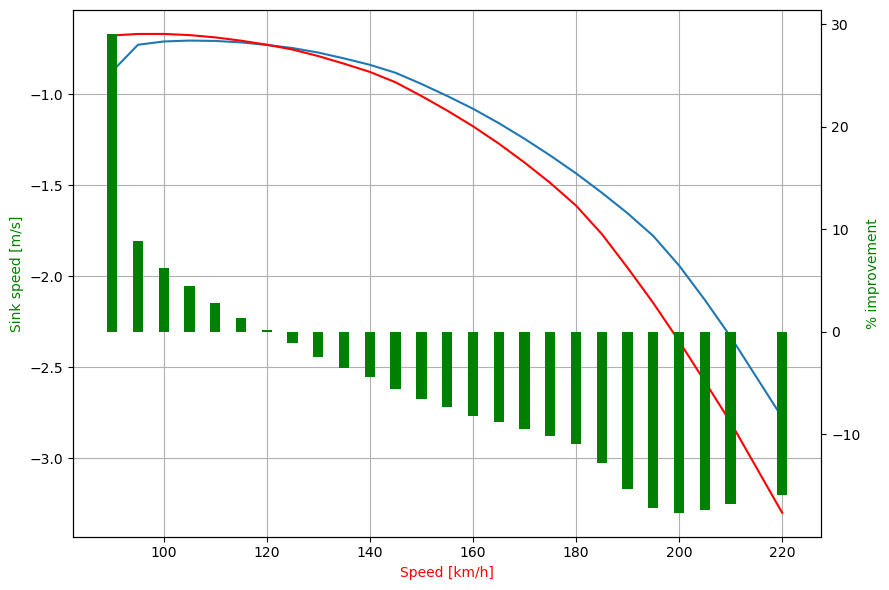

In [23]:
with open("POLARS/JS4_BASELINE_52wl.txt","r") as infile:
    Sink_Data = np.loadtxt(infile, dtype=float, skiprows=0, unpack=True)

fig, ax1 = plt.subplots(figsize=(9, 6))

plt.plot(Sink_Data[0],Sink_Data[1])
plt.plot(Flight_Data[0],Sink_collector,color="red")
plt.grid()
plt.rcParams['figure.figsize'] = [10, 4]

ax2 = ax1.twinx()

#ax1.plot(x, y1, color = 'g')
#ax2.plot(x, y2, color = 'b')
 
# giving labels to the axises
ax1.set_xlabel('Speed [km/h]', color = 'r')
ax1.set_ylabel('Sink speed [m/s]', color = 'g')
 
# secondary y-axis label
ax2.set_ylabel('% improvement', color = 'g')


Percentage = [0] * len(Sink_Data[0])
for i in range(0,len(Sink_Data[0]),1):
    Percentage[i] = '{:.3f}'.format(((Sink_collector[i]-Sink_Data[1][i])/Sink_collector[i])*100)
    Percentage[i] = -((Sink_collector[i]-Sink_Data[1][i])/Sink_collector[i])*100
    #print(Percentage[i], Sink_Data[0][i])

plt.bar(Sink_Data[0], Percentage, color ='green',width = 2)
plt.show()




# POLAR OPTIMIZE FLAPS

In [397]:
WingFile = 'JS6_b_wing_18m.dat'
FuselageFile = 'JS3_Fuselage.dat'
AirfoilsFile = 'JS6_b_Airfoil_Data.dat'
Flap_File = 'JS3_Flap_Data.dat'               # not used here
Speed_File = 'JS6_Speed_Data_flaprange.dat'   # must have range of flap settings

In [ ]:
#SAMPLE CODE  Multi-Processor III (optimize flaps)


with open(Speed_File,"r") as infile:
    Flight_Data = np.loadtxt(infile, dtype=float, skiprows=0, unpack=True)

#print(len(Flight_Data[0]))
Count_list = list(range(0, len(Flight_Data[0])))
Sink_collector = []



rho = 1.225
mu = 1.789e-5
#V_inf =33.30       #[m/s]
alpha = 5          # angle of attack (only for Lifting line solver) [deg]
a = 2*np.pi        # lift curve slope
Weight = 550*9.81  #[N]
Bank_Angle = 0     #[deg]
Flap = 0           #[0 degrees is neutral or no flap]
Pressure_altitude = 0  #[m]
OAT = 15  #[Deg]

winglet = 8   #[% contribution at low speeds]


#Optional calls
Area,Span,AR, WingData = GetWingData(WingFile)
print("Area=" + str(Area*2) + "  " + "Span=" + str(Span*2) + "  " + "AR=" + str(AR))
n = 60
cl,y_pos,CL_theory,delta = Solve_LL(WingData,Span,AR,alpha,a,n)  
print("efficiency=" + str(1/(1+delta)))


rho, mu = Get_rho_mu(Pressure_altitude,OAT,rho)

def calculate_LD(i):
    
    
    V = Flight_Data[0][i]
    CL = (2*Weight) /  (rho*(V/3.6)**2  *   2*  Area    *    np.cos(np.deg2rad(Bank_Angle)))
    
    #Flap = Flight_Data[1][i]                           #From Speed FIle
    #Flap = Flap_Setting(Flap_File,V/3.6,rho,mu,CL)     #Auto Flap  JS3
    #Flap = 0                                           #Standard class
    
    CD_min = 0.1
    Flap_min = 99
    step = 1   
    for Flap in np.arange(float(Flight_Data[1][i]),float(Flight_Data[2][i])+step,step):
        CD,CL = Wing_CD(WingFile,AirfoilsFile,V/3.6,rho,mu,Bank_Angle,Weight,Flap,alpha,a,winglet)
        #print("CD=" + str(CD) + "  " + "CL=" + str(CL) + " FLAP=" +str(Flap) + " SPEED=" + str(V))
         
        if (CD < CD_min):
            CD_min = CD
            Flap_min = Flap
            Drag = Fuselage_Drag(FuselageFile,V/3.6) + (0.5*rho*((V/3.6)**2)*CD_min*Area*2) * 1.05
    print(V,Flap_min,(Weight/Drag))
    return(V*Drag/(Weight*-3.6))


num_processes = multiprocessing.cpu_count()
print(num_processes)



with multiprocessing.Pool(processes=num_processes) as pool:
    Sink_collector = pool.map(calculate_LD,Count_list)
       
print("\n"+"Done")
    

# OLD CODE

In [ ]:
#SAMPLE CODE  Multi-Processor II (with flaps)

with open(Speed_File,"r") as infile:
    Flight_Data = np.loadtxt(infile, dtype=float, skiprows=0, unpack=True)

AirfoilData  = GetAirfoilData(AirfoilsFile)
print(AirfoilData)    
Count_list = list(range(0, len(Flight_Data[0])))
Sink_collector = []


rho = 1.225
mu = 1.789e-5
#V_inf =33.30       #[m/s]
alpha = 5          # angle of attack (only for Lifting line solver) [deg]
a = 2*np.pi        # lift curve slope
Weight = 408*9.81  #[N]
Bank_Angle = 0     #[deg]
Flap = 0           #[0 degrees is neutral or no flap]
Pressure_altitude = 0  #[m]
OAT = 15  #[Deg]

winglet = 8   #[% contribution at low speeds]


#Optional calls
Area,Span,AR, WingData = GetWingData(WingFile)
print("Area=" + str(Area*2) + "  " + "Span=" + str(Span*2) + "  " + "AR=" + str(AR))
n = 60
cl,y_pos,CL_theory,delta = Solve_LL(WingData,Span,AR,alpha,a,n)  
print("efficiency=" + str(1/(1+delta)))


rho, mu = Get_rho_mu(Pressure_altitude,OAT,rho)
#print(rho,mu)

def calculate_LD(i):
    
    
    V = Flight_Data[0][i]
    CL = (2*Weight) /  (rho*(V/3.6)**2  *   2*  Area    *    np.cos(np.deg2rad(Bank_Angle)))
    
    #Flap = Flight_Data[1][i]                            #From Speed File
    #Flap = Flap_Setting(Flap_File,V/3.6,rho,mu,CL)     #Auto Flap  JS3
    Flap = 0                                           #Standard class
    
       
    
    CD,CL = Wing_CD(WingFile,AirfoilsFile,V/3.6,rho,mu,Bank_Angle,Weight,Flap,alpha,a,winglet)
    #CD,CL = Wing_CD(WingFile,AirfoilsFile,flight_par[i][0]/3.6,rho,mu,Bank_Angle,Weight,flight_par[i][1],alpha,a,winglet)
    #print("CD=" + str(CD) + "  " + "CL=" + str(CL))
    Drag = Fuselage_Drag(FuselageFile,V/3.6) + (0.5*rho*((V/3.6)**2)*CD*Area*2) * 1.05

    #print(V,'{:.2f}'.format(V*Drag/(Weight*-3.6)),'{:.2f}'.format(CL),Flap)
    #print(str(flight_par[i][0]) + " " + str(flight_par[i][0]*Drag/(Weight*-3.6)) + " " + str(Weight/Drag) + " " + str(Flap)
    if (V*Drag/(Weight*-3.6)) < -10.0:
        print(V,Flap)
    return(V*Drag/(Weight*-3.6))


num_processes = multiprocessing.cpu_count()
print(num_processes)



with multiprocessing.Pool(processes=num_processes) as pool:
    Sink_collector = pool.map(calculate_LD,Count_list)
       
print("\n"+"Done")
    

In [ ]:
# AIRFOIL ANALYSIS (OPTIONAL)   SLOW


rho = 1.225
mu = 1.789e-5
#V_inf = 40         #[m/s]
alpha = 5          # angle of attack (only for Lifting line solver) [deg]
a = 2*np.pi        # lift curve slope
Weight = 550*9.81  #[N]
Bank_Angle = 0     #[deg]
Flap = 0           #[0 degrees is neutral or no flap]
Pressure_altitude = 0  #[m]
OAT = 15  #[Deg]



#rho, mu = Get_rho_mu(Pressure_altitude,OAT,rho)
Area,Span,AR, WingData = GetWingData("JS6_wing_18m.dat")
    
    

Airfoil_foldername = "./AIRFOILS/"
with open("AIRFOIL_ANALYSIS.dat", 'r') as infile:
     Airfoils = np.loadtxt(infile, dtype=str, skiprows=0, unpack=True)
#print(Airfoils)
        
ChordData  = GetAirfoilData("JS6_Airfoil_Data.dat")
#print(ChordData)

with open("SPEED_SETTINGS.dat", 'r') as infile:
     SPEEDFLAP = np.loadtxt(infile, dtype=str, skiprows=0, unpack=True)

#print(SPEEDFLAP)

#print(len(Airfoils[0]))
#print(len(ChordData[0]))

filename = "Airfoil_analysis.csv"
Station = 1

csvfile = open(filename, 'w')
csvwriter = csv.writer(csvfile) 



csvheader = Airfoils[0]
csvheader = np.insert(csvheader, 0,"CL")
print(csvheader)
csvwriter.writerow(csvheader)   


for k in range(0,len(SPEEDFLAP[0]),1):
    #for i in range(0,len(ChordData[0])-3,1):
    i = Station-1
    Airfoil_min = "none"
    flapsetting = "99"
    #drag_collector = []
    V_inf = float(SPEEDFLAP[0][k])/3.6
    Re = rho*V_inf*float(ChordData[1][i])/mu
    #print(V_inf,Re)
    CL = (2*Weight) /  (rho*(V_inf)**2  *2*Area*np.cos(np.deg2rad(Bank_Angle)))    

    print("Station->"+str(i+1) + "  " + str(SPEEDFLAP[0][k])+"km/h  " + "CL = "+str(CL) + " RE = " + str(Re))
    Cd_min = 0.1
    ISCONV = True
    rowlist = []
    flaplist = []
    
    rowlist.append(float(CL))
    for j in range(0,len(Airfoils[0]),1):
        step = 1
        Cd_min_airfoil = 0.1
        for m in np.arange(float(SPEEDFLAP[1][k]),float(SPEEDFLAP[2][k])+step,step):


            # call XFOIL DLL
            xpos = float(Airfoils[1][j])
            ypos = float(Airfoils[2][j])
            AOA, Cd,Cm,ISCONV = CallXfoilcl(CL,Re,Airfoil_foldername + Airfoils[0][j],m,xpos,ypos)
            #print(Airfoil_foldername+Airfoils[0][j],Re,m,Cd)
            
            if Cd < Cd_min_airfoil and ISCONV == True:
                Cd_min_airfoil = Cd
                flapsetting_airfoil = m
            if Cd < Cd_min and ISCONV == True:
                Cd_min = Cd
                Airfoil_min = Airfoils[0][j]
                flapsetting = m
        
        rowlist.append('{:.5f}'.format(Cd_min_airfoil))   
        flaplist.append(flapsetting_airfoil)

    print(Airfoil_min,flapsetting)    
    print(rowlist)
    print(flaplist)
    csvwriter.writerow(rowlist) 
    
csvfile.close()
print("Done")       
    

In [ ]:
#SAMPLE CODE


flight_par =[ 
[220,0],
[210,0],
[200,0],
[190,0],
[180,5],
[170,5],
[160,5],
[151,13.5],
[140,13.5],
[130,13.5],
[120,16.7],
[110,16.7],
[100,16.7],
[90,20],
[85,20],    
]


WingFile = 'wing_18.dat'
FuselageFile = 'JS3_Fuselage.dat'
AirfoilsFile = 'Airfoil_Data.dat'
Flap_File = 'JS3_Flap_Data.dat'

rho = 1.225
mu = 1.789e-5
#V_inf =33.30       #[m/s]
alpha = 5          # angle of attack (only for Lifting line solver) [deg]
a = 2*np.pi        # lift curve slope
Weight = 500*9.81  #[N]
Bank_Angle = 0     #[deg]
Flap = 0           #[0 degrees is neutral or no flap]
Pressure_altitude = 0  #[m]
OAT = 15  #[Deg]

winglet = 5   #[% contribution at low speeds]


#Optional call
Area,Span,AR, WingData = GetWingData(WingFile)
print("Area=" + str(Area*2) + "  " + "Span=" + str(Span*2) + "  " + "AR=" + str(AR))




rho, mu = Get_rho_mu(Pressure_altitude,OAT,rho)
#print(rho,mu)

for i in range(0,len(flight_par),1):
    
    CL = (2*Weight) /  (rho*(flight_par[i][0]/3.6)**2  *   2*  Area    *    np.cos(np.deg2rad(Bank_Angle)))
    
    Flap = flight_par[i][1]
    #Flap = Flap_Setting(Flap_File,flight_par[i][0]/3.6,rho,mu,CL)     #Auto Flap
    
    CD,CL = Wing_CD(WingFile,AirfoilsFile,flight_par[i][0]/3.6,rho,mu,Bank_Angle,Weight,Flap,alpha,a,winglet)
    #CD,CL = Wing_CD(WingFile,AirfoilsFile,flight_par[i][0]/3.6,rho,mu,Bank_Angle,Weight,flight_par[i][1],alpha,a,winglet)
    #print("CD=" + str(CD) + "  " + "CL=" + str(CL))
    Drag = Fuselage_Drag(FuselageFile,flight_par[i][0]/3.6) + (0.5*rho*((flight_par[i][0]/3.6)**2)*CD*Area*2) * 1.05

    print(flight_par[i][0],'{:.2f}'.format(flight_par[i][0]*Drag/(Weight*-3.6)),CL,Flap)
    #print(str(flight_par[i][0]) + " " + str(flight_par[i][0]*Drag/(Weight*-3.6)) + " " + str(Weight/Drag) + " " + str(Flap) )
